In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import contractions
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from collections import Counter
import string
from textblob import TextBlob
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.metrics import accuracy_score, f1_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\okan_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\okan_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Loading the data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
df_test.shape

(3263, 4)

In [6]:
len(df_train)

7613

In [7]:
len(df_test)

3263

# **Exploratory Data Analysis (EDA)**

In [8]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [9]:
df_train.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,7613.0,NaN,NaN,NaN,5441.934848,3137.11609,1.0,2734.0,5408.0,8146.0,10873.0
keyword,7552,221,fatalities,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,5080,3341,USA,104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
text,7613,7503,11-Year-Old Boy Charged With Manslaughter of T...,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
target,7613.0,NaN,NaN,NaN,0.42966,0.49506,0.0,0.0,0.0,1.0,1.0


In [10]:
# check duplication
df_train.duplicated().sum()

0

In [11]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [12]:
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

Not hakaret: 4342
hakaret: 3271


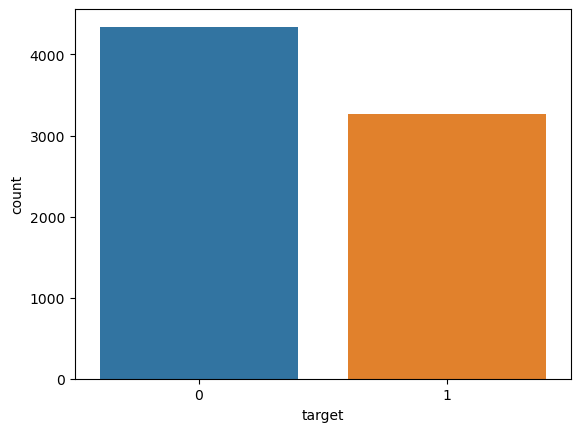

In [13]:
sns.countplot(x="target",data=df_train)

print("Not hakaret: %s"%(df_train["target"].value_counts()[0]))
print("hakaret: %s"%(df_train["target"].value_counts()[1]))

In [14]:
# explore length of target
df_train["length_of_text"]=df_train["text"].apply(lambda x: len(x.split()))
df_test["length_of_text"]=df_test["text"].apply(lambda x: len(x.split()))

In [15]:
df_train

,id,keyword,location,text,target,length_of_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,11
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,20
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,8
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,19


In [16]:
df_train = df_train.drop(['id', 'keyword', 'location'], axis=1)

In [17]:
df_train.head()

,text,target,length_of_text
0,Our Deeds are the Reason of this #earthquake M...,1,13
1,Forest fire near La Ronge Sask. Canada,1,7
2,All residents asked to 'shelter in place' are ...,1,22
3,"13,000 people receive #wildfires evacuation or...",1,8
4,Just got sent this photo from Ruby #Alaska as ...,1,16


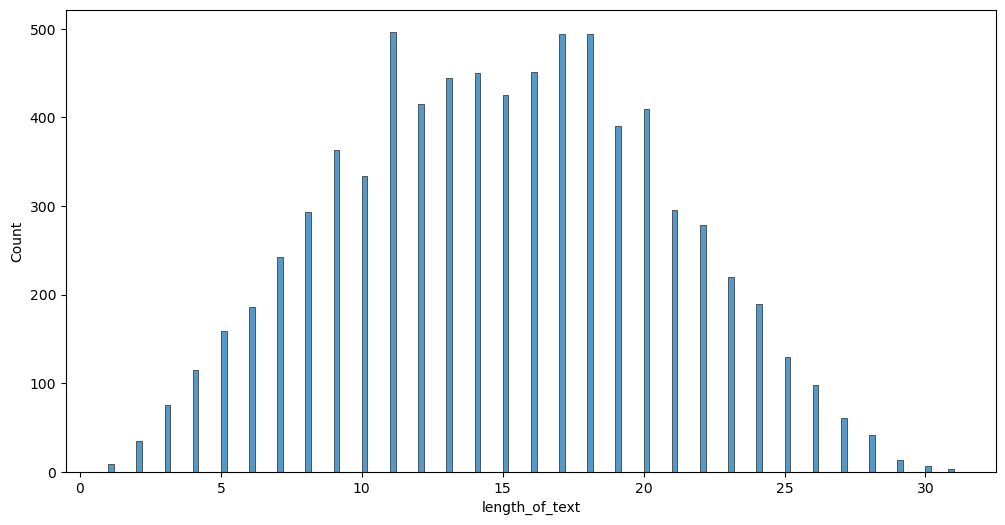

In [18]:
plt.figure(figsize=(12,6))
sns.histplot(x="length_of_text",data=df_train,bins=150);

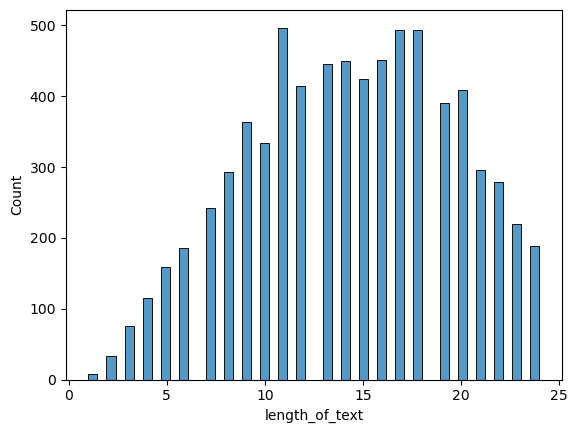

In [19]:
sns.histplot (df_train.length_of_text[df_train.length_of_text < 25], bins=50);

In [20]:
# highest word count
df_train.sort_values(by="length_of_text",ascending=False)[:5]

,text,target,length_of_text
954,If you have a son or a daughter would you like...,0,31
5005,I remember when I worked at Mcdonalds I use to...,0,31
4432,When u get mugged with ur gf u come up with th...,0,31
2089,I will only call or text 2 niggas my bff &amp;...,0,30
6794,This is a tragedy: I added the wrong book to m...,0,30


In [21]:
# lowest word count
df_train.sort_values(by="length_of_text",ascending=True)[:5]

,text,target,length_of_text
3667,Fatality!,0,1
5115,Err:509,0,1
4971,Meltdown,0,1
6705,Thunder???,0,1
24,LOOOOOOL,0,1


# **Text Pre-Processing**

In [22]:
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
# lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    doc = contractions.fix(doc)
# tokenize document
    tokens = nltk.word_tokenize(doc)
# filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
# re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(list(df_train['text']))
norm_corpus

array(['deeds reason earthquake may allah forgive us',
       'forest fire near la ronge sask canada',
       'residents asked shelter place notified officers evacuation shelter place orders expected',
       ..., 'utckm volcano hawaii httptcozdtoydebj',
       'police investigating ebike collided car little portugal ebike rider suffered serious nonlife threatening injuries',
       'latest homes razed northern california wildfire abc news httptcoymyrskqd'],
      dtype='<U138')

In [23]:
df_train.text.shape

(7613,)

In [24]:
df_train.text.head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

# **Build train and test datasets**

In [25]:
df_test.head()

,id,keyword,location,text,length_of_text
0,0,NaN,NaN,Just happened a terrible car crash,6
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",9
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",19
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,4
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,8


In [26]:
df_test2 = df_test.iloc[:,3:]

In [27]:
df_test2.head()

,text,length_of_text
0,Just happened a terrible car crash,6
1,"Heard about #earthquake is different cities, s...",9
2,"there is a forest fire at spot pond, geese are...",19
3,Apocalypse lighting. #Spokane #wildfires,4
4,Typhoon Soudelor kills 28 in China and Taiwan,8


In [28]:
df_id = df_test.iloc[:,:1]

In [29]:
df_id

,id
0,0
1,2
2,3
3,9
4,11
...,...
3258,10861
3259,10865
3260,10868
3261,10874


In [30]:
X = df_train.drop(['target'], axis = 1)
y = df_train['target']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((6090, 2), (1523, 2))

In [31]:
Counter(y_train), Counter(y_test)

(Counter({1: 2622, 0: 3468}), Counter({1: 649, 0: 874}))

# **Basic NLP Count based Features**

*  **Word Count:** total number of words in the documents
*  **Character Count:** total number of characters in the documents
*  **Average Word Density:** average length of the words used in the documents
*  **Puncutation Count:** total number of punctuation marks in the documents
*  **Upper Case Count:** total number of upper count words in the documents
*  **Title Word Count:** total number of proper case (title) words in the documents

In [32]:
df_train

,text,target,length_of_text
0,Our Deeds are the Reason of this #earthquake M...,1,13
1,Forest fire near La Ronge Sask. Canada,1,7
2,All residents asked to 'shelter in place' are ...,1,22
3,"13,000 people receive #wildfires evacuation or...",1,8
4,Just got sent this photo from Ruby #Alaska as ...,1,16
...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,11
7609,@aria_ahrary @TheTawniest The out of control w...,1,20
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,8
7611,Police investigating after an e-bike collided ...,1,19


In [33]:
#pip install textstat

In [34]:
import textstat
# calculate total number of characters
X_train['char_count'] = X_train['text'].apply(len)
# calculate total number of words
X_train['word_count'] = X_train['text'].apply(lambda x: len(x.split()))
# # calculate average word density
X_train['word_density'] = X_train['char_count'] / (X_train['word_count']+1)
# calculate total number of punctuaction marks
X_train['punctuation_count'] = X_train['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))
# calculate total number of title-cased words
X_train['title_word_count'] = X_train['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
# calculate total number of upper-cased words
X_train['upper_case_word_count'] = X_train['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
# Length of longest word
X_train['longest_word_length'] = X_train['text'].apply(lambda x: max([len(word) for word in x.split()]))
# Reading ease
X_train['reading_ease'] = X_train['text'].apply(textstat.flesch_reading_ease)

# calculate total number of characters
X_test['char_count'] = X_test['text'].apply(len)
# calculate total number of words
X_test['word_count'] = X_test['text'].apply(lambda x: len(x.split()))
# calculate average word density
X_test['word_density'] = X_test['char_count'] / (X_test['word_count']+1)
# calculate total number of punctuaction marks
X_test['punctuation_count'] = X_test['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))
# calculate total number of title-cased words
X_test['title_word_count'] = X_test['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
# calculate total number of upper-cased words
X_test['upper_case_word_count'] = X_test['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
# Length of longest word
X_test['longest_word_length'] = X_test['text'].apply(lambda x: max([len(word) for word in x.split()]))
# Reading ease
X_test['reading_ease'] = X_test['text'].apply(textstat.flesch_reading_ease)

# calculate total number of characters
df_test2['char_count'] = df_test2['text'].apply(len)
# calculate total number of words
df_test2['word_count'] = df_test2['text'].apply(lambda x: len(x.split()))
# calculate average word density
df_test2['word_density'] = df_test2['char_count'] / (df_test2['word_count']+1)
# calculate total number of punctuaction marks
df_test2['punctuation_count'] = df_test2['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))
# calculate total number of title-cased words
df_test2['title_word_count'] = df_test2['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
# calculate total number of upper-cased words
df_test2['upper_case_word_count'] = df_test2['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
# Length of longest word
df_test2['longest_word_length'] = df_test2['text'].apply(lambda x: max([len(word) for word in x.split()]))
# Reading ease
df_test2['reading_ease'] = df_test2['text'].apply(textstat.flesch_reading_ease)

In [35]:
X_train.head()

,text,length_of_text,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,longest_word_length,reading_ease
4996,Courageous and honest analysis of need to use ...,18,140,18,7.368421,8,5,0,23,28.50
3263,@ZachZaidman @670TheScore wld b a shame if tha...,15,98,15,6.125000,4,0,0,13,81.63
4907,Tell @BarackObama to rescind medals of 'honor'...,22,143,22,6.217391,12,4,4,23,68.77
2855,Worried about how the CA drought might affect ...,17,118,17,6.555556,8,7,1,22,62.85
4716,@YoungHeroesID Lava Blast &amp; Power Red #Pan...,9,82,9,8.200000,6,4,0,14,11.58


In [36]:
df_test2.shape

(3263, 10)

In [75]:
#X_train.drop(columns=['title_word_count', 'upper_case_word_count'], inplace=True, axis=0)
#X_test.drop(columns=['title_word_count', 'upper_case_word_count'], inplace=True, axis=0)
#df_test2.drop(columns=['title_word_count', 'upper_case_word_count'], inplace=True, axis=0)

In [37]:
df_test2.head()

,text,length_of_text,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,longest_word_length,reading_ease
0,Just happened a terrible car crash,6,34,6,4.857143,0,1,0,8,73.85
1,"Heard about #earthquake is different cities, s...",9,64,9,6.400000,3,1,0,11,62.34
2,"there is a forest fire at spot pond, geese are...",19,96,19,4.800000,2,1,1,7,86.03
3,Apocalypse lighting. #Spokane #wildfires,4,40,4,8.000000,3,2,0,10,33.58
4,Typhoon Soudelor kills 28 in China and Taiwan,8,45,8,5.000000,0,4,0,8,71.82


In [38]:
X_train.head()

,text,length_of_text,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,longest_word_length,reading_ease
4996,Courageous and honest analysis of need to use ...,18,140,18,7.368421,8,5,0,23,28.50
3263,@ZachZaidman @670TheScore wld b a shame if tha...,15,98,15,6.125000,4,0,0,13,81.63
4907,Tell @BarackObama to rescind medals of 'honor'...,22,143,22,6.217391,12,4,4,23,68.77
2855,Worried about how the CA drought might affect ...,17,118,17,6.555556,8,7,1,22,62.85
4716,@YoungHeroesID Lava Blast &amp; Power Red #Pan...,9,82,9,8.200000,6,4,0,14,11.58


# **Sentiment Analysis**

In [39]:
# calculate review's sentiment
x_train_snt_obj = X_train['text'].apply(lambda row: TextBlob(row).sentiment)
# create a column for polarity scores
X_train['Polarity'] = [obj.polarity for obj in x_train_snt_obj.values]
# create a column for subjectivity scores
X_train['Subjectivity'] = [obj.subjectivity for obj in x_train_snt_obj.values]

# calculate review's sentiment
x_test_snt_obj = X_test['text'].apply(lambda row: TextBlob(row).sentiment)
# create a column for polarity scores
X_test['Polarity'] = [obj.polarity for obj in x_test_snt_obj.values]
# create a column for subjectivity scores
X_test['Subjectivity'] = [obj.subjectivity for obj in x_test_snt_obj.values]

# calculate review's sentiment
df_test2_snt_obj = df_test2['text'].apply(lambda row: TextBlob(row).sentiment)
# create a column for polarity scores
df_test2['Polarity'] = [obj.polarity for obj in df_test2_snt_obj.values]
# create a column for subjectivity scores
df_test2['Subjectivity'] = [obj.subjectivity for obj in df_test2_snt_obj.values]

In [40]:
X_train.head()

,text,length_of_text,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,longest_word_length,reading_ease,Polarity,Subjectivity
4996,Courageous and honest analysis of need to use ...,18,140,18,7.368421,8,5,0,23,28.50,0.166667,0.333333
3263,@ZachZaidman @670TheScore wld b a shame if tha...,15,98,15,6.125000,4,0,0,13,81.63,0.000000,0.000000
4907,Tell @BarackObama to rescind medals of 'honor'...,22,143,22,6.217391,12,4,4,23,68.77,0.000000,0.000000
2855,Worried about how the CA drought might affect ...,17,118,17,6.555556,8,7,1,22,62.85,-0.125000,1.000000
4716,@YoungHeroesID Lava Blast &amp; Power Red #Pan...,9,82,9,8.200000,6,4,0,14,11.58,0.000000,0.000000


In [41]:
X_test.head()

,text,length_of_text,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,longest_word_length,reading_ease,Polarity,Subjectivity
2644,So you have a new weapon that can cause un-ima...,11,66,11,5.500000,2,1,0,13,77.23,0.136364,0.454545
2227,The f$&amp;@ing things I do for #GISHWHES Just...,21,119,21,5.409091,10,4,2,13,68.10,0.000000,0.000000
5448,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,15,125,15,7.812500,12,3,2,22,22.41,0.000000,0.000000
132,Aftershock back to school kick off was great. ...,21,114,21,5.181818,3,3,1,10,89.75,0.400000,0.625000
6845,in response to trauma Children of Addicts deve...,17,105,17,5.833333,3,2,0,14,29.86,0.000000,0.000000


In [42]:
df_test2.head()

,text,length_of_text,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,longest_word_length,reading_ease,Polarity,Subjectivity
0,Just happened a terrible car crash,6,34,6,4.857143,0,1,0,8,73.85,-1.00,1.00
1,"Heard about #earthquake is different cities, s...",9,64,9,6.400000,3,1,0,11,62.34,0.25,0.55
2,"there is a forest fire at spot pond, geese are...",19,96,19,4.800000,2,1,1,7,86.03,0.00,0.00
3,Apocalypse lighting. #Spokane #wildfires,4,40,4,8.000000,3,2,0,10,33.58,0.00,0.00
4,Typhoon Soudelor kills 28 in China and Taiwan,8,45,8,5.000000,0,4,0,8,71.82,0.00,0.00


In [43]:
df_test2.shape

(3263, 12)

In [46]:
X_test.shape

(1523, 12)

In [48]:
# load stopwords default nltk list
stop_words = stopwords.words('english')

# load up a simple porter stemmer - nothing fancy
ps = PorterStemmer()

def simple_text_preprocessor(document):
    """Perform basic text pre-processing tasks."""

# lower case
    document = str(document).lower()

# expand contractions
    document = contractions.fix(document)

# remove unnecessary characters
    document = re.sub(r'[^a-zA-Z]',r' ', document)
    document = re.sub(r'nbsp', r'', document)
    document = re.sub(' +', ' ', document)

# simple porter stemming
    document = ' '.join([ps.stem(word) for word in document.split()])

# stopwords removal
    document = ' '.join([word for word in document.split() if word not in stop_words])

    return document

# vectorize function
stp = np.vectorize(simple_text_preprocessor)

In [49]:
# create a new column with cleaned text
X_train['Clean Headline'] = stp(X_train['text'].values)
X_test['Clean Headline'] = stp(X_test['text'].values)
df_test2['Clean Headline'] = stp(df_test2['text'].values)
# check first 5 rows
X_train.head()

,text,length_of_text,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,longest_word_length,reading_ease,Polarity,Subjectivity,Clean Headline
4996,Courageous and honest analysis of need to use ...,18,140,18,7.368421,8,5,0,23,28.50,0.166667,0.333333,courag honest analysi need use atom bomb hiros...
3263,@ZachZaidman @670TheScore wld b a shame if tha...,15,98,15,6.125000,4,0,0,13,81.63,0.000000,0.000000,zachzaidman thescor wld b shame golf cart beca...
4907,Tell @BarackObama to rescind medals of 'honor'...,22,143,22,6.217391,12,4,4,23,68.77,0.000000,0.000000,tell barackobama rescind medal honor given us ...
2855,Worried about how the CA drought might affect ...,17,118,17,6.555556,8,7,1,22,62.85,-0.125000,1.000000,worri ca drought might affect extrem weather d...
4716,@YoungHeroesID Lava Blast &amp; Power Red #Pan...,9,82,9,8.200000,6,4,0,14,11.58,0.000000,0.000000,youngheroesid lava blast amp power red panther...


In [51]:
from collections import Counter
# Concatenate all tweets into a single string
all_tweets = ' '.join(X_train['Clean Headline'])
# Split the string into words and count the frequency of each word
word_counts = Counter(all_tweets.split())
# Get the 5 most common words
most_common_words = [word for word, count in word_counts.most_common(5)]
# Define a function to count how many of the most common words are present in a tweet
def count_most_common(tweet):
    tweet_words = set(tweet.split())
    common_words = set(most_common_words)
    return len(tweet_words.intersection(common_words))
# Apply the function to the 'text' column and create a new feature called 'most_common_count'
X_train['most_common_count'] = X_train['Clean Headline'].apply(count_most_common)
#----------------------------------------------------------------------------------
all_tweets = ' '.join(X_test['Clean Headline'])
word_counts = Counter(all_tweets.split())
most_common_words = [word for word, count in word_counts.most_common(5)]
def count_most_common(tweet):
    tweet_words = set(tweet.split())
    common_words = set(most_common_words)
    return len(tweet_words.intersection(common_words))
X_test['most_common_count'] = X_test['Clean Headline'].apply(count_most_common)
#--------------------------------------------------------------------------------
all_tweets = ' '.join(df_test2['Clean Headline'])
word_counts = Counter(all_tweets.split())
most_common_words = [word for word, count in word_counts.most_common(5)]
def count_most_common(tweet):
    tweet_words = set(tweet.split())
    common_words = set(most_common_words)
    return len(tweet_words.intersection(common_words))
df_test2['most_common_count'] = df_test2['Clean Headline'].apply(count_most_common)

In [52]:
X_train_metadata = X_train.drop(['text', 'Clean Headline'], axis=1).reset_index(drop=True)
X_test_metadata = X_test.drop(['text', 'Clean Headline'], axis=1).reset_index(drop=True)
df_test2_metadata = df_test2.drop(['text', 'Clean Headline'], axis=1).reset_index(drop=True)

In [53]:
X_train_metadata.shape

(6090, 12)

In [54]:
X_test_metadata.shape

(1523, 12)

In [55]:
df_test2_metadata.shape

(3263, 12)

In [56]:
X_train_metadata.head()

,length_of_text,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,longest_word_length,reading_ease,Polarity,Subjectivity,most_common_count
0,18,140,18,7.368421,8,5,0,23,28.50,0.166667,0.333333,2
1,15,98,15,6.125000,4,0,0,13,81.63,0.000000,0.000000,0
2,22,143,22,6.217391,12,4,4,23,68.77,0.000000,0.000000,2
3,17,118,17,6.555556,8,7,1,22,62.85,-0.125000,1.000000,2
4,9,82,9,8.200000,6,4,0,14,11.58,0.000000,0.000000,0


In [57]:
X_test_metadata.head()

,length_of_text,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,longest_word_length,reading_ease,Polarity,Subjectivity,most_common_count
0,11,66,11,5.500000,2,1,0,13,77.23,0.136364,0.454545,0
1,21,119,21,5.409091,10,4,2,13,68.10,0.000000,0.000000,0
2,15,125,15,7.812500,12,3,2,22,22.41,0.000000,0.000000,2
3,21,114,21,5.181818,3,3,1,10,89.75,0.400000,0.625000,1
4,17,105,17,5.833333,3,2,0,14,29.86,0.000000,0.000000,0


In [58]:
df_test2_metadata.head()

,length_of_text,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,longest_word_length,reading_ease,Polarity,Subjectivity,most_common_count
0,6,34,6,4.857143,0,1,0,8,73.85,-1.00,1.00,0
1,9,64,9,6.400000,3,1,0,11,62.34,0.25,0.55,0
2,19,96,19,4.800000,2,1,1,7,86.03,0.00,0.00,0
3,4,40,4,8.000000,3,2,0,10,33.58,0.00,0.00,0
4,8,45,8,5.000000,0,4,0,8,71.82,0.00,0.00,0


In [59]:
# instatiate vectorizer
cv = CountVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1, 1))

# fit vectorizer to 'Clean Review' and convert it to numpy array
X_traincv = cv.fit_transform(X_train['Clean Headline']).toarray()
# create a pandas DataFrame
X_traincv = pd.DataFrame(X_traincv, columns=cv.get_feature_names_out())

# use vectorizer to transform 'Clean Review' and convert it to numpy array
X_testcv = cv.transform(X_test['Clean Headline']).toarray()
# create a pandas DataFrame
X_testcv = pd.DataFrame(X_testcv, columns=cv.get_feature_names_out())

# use vectorizer to transform 'Clean Review' and convert it to numpy array
df_test2cv = cv.transform(df_test2['Clean Headline']).toarray()
# create a pandas DataFrame
df_test2cv = pd.DataFrame(df_test2cv, columns=cv.get_feature_names_out())

# check first 5 rows
X_traincv.head()

,aa,aaaa,aaaaaaallll,aaarrrgghhh,aac,aag,aal,aamir,aan,aannnnd,...,zz,zzcbbqyj,zzk,zznbvfuvo,zzpojgngaj,zzr,zzsee,zztbvjypn,zzuz,zzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
# concatenate the 2 dataframes
X_train_combo = pd.concat([X_train_metadata, X_traincv], axis=1)
X_test_combo = pd.concat([X_test_metadata, X_testcv], axis=1)
df_test2_combo = pd.concat([df_test2_metadata, df_test2cv], axis=1)
# check first 5 rows
X_train_combo.head()

,length_of_text,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,longest_word_length,reading_ease,Polarity,...,zz,zzcbbqyj,zzk,zznbvfuvo,zzpojgngaj,zzr,zzsee,zztbvjypn,zzuz,zzzz
0,18,140,18,7.368421,8,5,0,23,28.50,0.166667,...,0,0,0,0,0,0,0,0,0,0
1,15,98,15,6.125000,4,0,0,13,81.63,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,22,143,22,6.217391,12,4,4,23,68.77,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,17,118,17,6.555556,8,7,1,22,62.85,-0.125000,...,0,0,0,0,0,0,0,0,0,0
4,9,82,9,8.200000,6,4,0,14,11.58,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [61]:
X_train_combo.head()

,length_of_text,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,longest_word_length,reading_ease,Polarity,...,zz,zzcbbqyj,zzk,zznbvfuvo,zzpojgngaj,zzr,zzsee,zztbvjypn,zzuz,zzzz
0,18,140,18,7.368421,8,5,0,23,28.50,0.166667,...,0,0,0,0,0,0,0,0,0,0
1,15,98,15,6.125000,4,0,0,13,81.63,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,22,143,22,6.217391,12,4,4,23,68.77,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,17,118,17,6.555556,8,7,1,22,62.85,-0.125000,...,0,0,0,0,0,0,0,0,0,0
4,9,82,9,8.200000,6,4,0,14,11.58,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [62]:
df_test2_combo.head()

,length_of_text,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,longest_word_length,reading_ease,Polarity,...,zz,zzcbbqyj,zzk,zznbvfuvo,zzpojgngaj,zzr,zzsee,zztbvjypn,zzuz,zzzz
0,6,34,6,4.857143,0,1,0,8,73.85,-1.00,...,0,0,0,0,0,0,0,0,0,0
1,9,64,9,6.400000,3,1,0,11,62.34,0.25,...,0,0,0,0,0,0,0,0,0,0
2,19,96,19,4.800000,2,1,1,7,86.03,0.00,...,0,0,0,0,0,0,0,0,0,0
3,4,40,4,8.000000,3,2,0,10,33.58,0.00,...,0,0,0,0,0,0,0,0,0,0
4,8,45,8,5.000000,0,4,0,8,71.82,0.00,...,0,0,0,0,0,0,0,0,0,0


In [63]:
X_train_combo.shape

(6090, 16128)

In [64]:
df_test2_combo.shape

(3263, 16128)

# **Model Training and Evaluation**

In [65]:
y_train

4996    1
3263    0
4907    1
2855    1
4716    0
       ..
5226    0
5390    0
860     0
7603    1
7270    1
Name: target, Length: 6090, dtype: int64

In [66]:
df_test_id = df_test['id']

In [67]:
X_test_combo.shape

(1523, 16128)

In [68]:
lr = LogisticRegression(C=1, penalty='l2', random_state=42, solver='liblinear')
lr.fit(X_train_combo, y_train)
predictions = lr.predict(X_test_combo)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       874
           1       0.80      0.71      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



In [69]:
len(predictions)

1523

In [70]:
result = pd.DataFrame(predictions) 
result.columns = ["prediction"]

In [71]:
result

,prediction
0,0
1,0
2,1
3,0
4,0
...,...
1518,0
1519,1
1520,1
1521,1


In [72]:
pd.DataFrame(confusion_matrix(y_test, predictions))

,0,1
0,756,118
1,190,459


In [73]:
df_test2_combo.shape

(3263, 16128)

In [74]:
X_train_combo.shape

(6090, 16128)

In [75]:
import numpy as np

# X_train_combo verilerini 3 boyutlu bir tensöre dönüştürme
X_train_lstm = X_train_combo.values.reshape((X_train_combo.shape[0], 1, X_train_combo.shape[1]))

# X_test_combo verilerini 3 boyutlu bir tensöre dönüştürme
X_test_lstm = X_test_combo.values.reshape((X_test_combo.shape[0], 1, X_test_combo.shape[1]))


In [76]:
X_train_lstm.shape

(6090, 1, 16128)

In [77]:
y_train.shape

(6090,)

In [78]:
X_test_lstm.shape

(1523, 1, 16128)

In [79]:
y_test.shape

(1523,)

In [114]:
"""
import numpy as np

X_train_lstm = np.array(X_train_lstm)
X_test_lstm = np.array(X_test_lstm)
y_train = np.array(y_train)
y_test = np.array(y_test)
"""

'\nimport numpy as np\n\nX_train_lstm = np.array(X_train_lstm)\nX_test_lstm = np.array(X_test_lstm)\ny_train = np.array(y_train)\ny_test = np.array(y_test)\n'

In [115]:
"""
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the LSTM model with more layers
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, validation_data=(X_test_lstm, y_test))

# Make predictions
predictions_lstm = model.predict(X_test_lstm)
"""

"\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import LSTM, Dense, Dropout\nfrom tensorflow.keras.optimizers import Adam\n\n# Define the LSTM model with more layers\nmodel = Sequential()\nmodel.add(LSTM(units=64, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))\nmodel.add(Dropout(0.2))\nmodel.add(LSTM(units=32))\nmodel.add(Dense(units=16, activation='relu'))\nmodel.add(Dense(units=1, activation='sigmoid'))\n\n# Compile the model\noptimizer = Adam(learning_rate=0.01)\nmodel.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])\n\n# Train the model\nhistory = model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, validation_data=(X_test_lstm, y_test))\n\n# Make predictions\npredictions_lstm = model.predict(X_test_lstm)\n"

In [116]:
"""
from sklearn.metrics import accuracy_score

# Tahmin sonuçlarını ikili bir diziye dönüştürme
binary_predictions = (predictions_lstm > 0.5)

# Doğruluk oranını hesaplama
accuracy = accuracy_score(y_test, binary_predictions)

print("Modelin doğruluk oranı: %.2f%%" % (accuracy * 100.0))
"""

'\nfrom sklearn.metrics import accuracy_score\n\n# Tahmin sonuçlarını ikili bir diziye dönüştürme\nbinary_predictions = (predictions_lstm > 0.5)\n\n# Doğruluk oranını hesaplama\naccuracy = accuracy_score(y_test, binary_predictions)\n\nprint("Modelin doğruluk oranı: %.2f%%" % (accuracy * 100.0))\n'

In [80]:
clf = BernoulliNB()
clf.fit(X_train_combo,y_train)
predictions_clf = clf.predict(X_test_combo)

In [81]:
print(classification_report(y_test, predictions_clf))

              precision    recall  f1-score   support

           0       0.78      0.92      0.84       874
           1       0.85      0.65      0.74       649

    accuracy                           0.80      1523
   macro avg       0.82      0.78      0.79      1523
weighted avg       0.81      0.80      0.80      1523



In [82]:
pd.DataFrame(confusion_matrix(y_test, predictions_clf))

,0,1
0,801,73
1,225,424
